In [1]:
%matplotlib inline

import geopandas
import regionmask

import pandas as pd
import xarray as xr
import os

from loca.data_catalog import load_monthly_cmip_hydro_datasets, resample_monthly_data
from loca.utils import calc_change

In [2]:
# create GeoDataFrame with all HUC2 elements
# huc 2 to 4, should WBDHU2.shp
dfs = []
hucs = list(range(1, 19))
for i in hucs:
    huc2_file = f'/glade/u/home/jhamman/projects/storylines/data/gis/WBD_{i:02d}_Shape/Shape/WBDHU2.shp'
    gdf = geopandas.GeoDataFrame.from_file(huc2_file)
    dfs.append(gdf)
gdf = pd.concat(dfs)
gdf.index = hucs
gdf.head()

,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,HUC2,NAME,SHAPE_LENG,SHAPE_AREA,geometry
1,{87290825-BAC9-4D07-8A32-E35A873C0BD1},None,None,None,None,20170816000649,2730131,49135499.18,198844.49,"CN,CT,MA,ME,NH,NY,RI,VT",01,New England Region,48.2984344819978,22.4854347168858,(POLYGON ((-73.02573148771478 41.2130396099875...
2,{4AEF9DDF-A9C6-400E-8FD8-180FD5C29F69},None,None,None,None,20170816000624,2730132,68320130.43,276482,"CT,DC,DE,MA,MD,NJ,NY,PA,RI,VA,VT,WV",02,Mid Atlantic Region,52.4177510650764,29.2456409326581,(POLYGON ((-73.0255572637567 41.21326637769545...
3,{9C77B5BA-946A-4537-BADD-990373DEFFBB},None,None,None,None,20170801122959,2730133,182774403.26,739662.42,"AL,FL,GA,LA,MS,NC,SC,TN,VA",03,South Atlantic-Gulf Region,69.8844227515357,71.0064380485419,"POLYGON ((-79.4782105318659 37.50766332823895,..."
4,{EBD12DC7-3886-4A92-BF58-E3147628761B},None,None,None,None,20170807182410,2730134,152474968.05,617044.85,"CN,IL,IN,ME,MI,MN,NH,NY,OH,PA,VT,WI",04,Great Lakes Region,166.233809505139,70.0158950771809,POLYGON ((-88.00263874050927 49.02244801140739...
5,{5C6AE09C-4CFC-4EBA-9344-A91AF35E73E8},None,None,None,None,20170627161550,2730135,104270021.21,421966.18,"IL,IN,KY,MD,NC,NY,OH,PA,TN,VA,WV",05,Ohio Region,61.3943869537108,43.813407644068,"POLYGON ((-79.03733301900854 42.4486251580696,..."


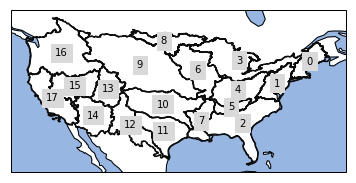

In [3]:
# Create a Regions object for masking
huc_mask = regionmask.Regions_cls('USmask', range(len(gdf)), gdf.STATES.values, list(map(str, hucs)), gdf.geometry.values)
huc_mask.plot()

In [4]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://10.148.10.27:60889 Dashboard: proxy/8787/status,Cluster Workers: 36 Cores: 144 Memory: 180.00 GB


In [5]:
read_cache = True
hist_data = {}
rcp4_data = {}
rcp8_data = {}
if read_cache:
    for key in ['loca', 'bcsd']:
        hist_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp4_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_rcp4.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp8_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_rcp8.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
print("read from path")
os.path.join(os.environ['TMPDIR'])

read from path


'/glade/scratch/jvano/temp'

<xarray.DataArray 'ET' (lat: 222, lon: 462)>
dask.array<shape=(222, 462), dtype=float32, chunksize=(222, 462)>
Coordinates:
  * lat      (lat) float32 25.1875 25.3125 25.4375 ... 52.5625 52.6875 52.8125
    time     datetime64[ns] 1950-01-01
  * lon      (lon) float32 -124.6875 -124.5625 -124.4375 ... -67.1875 -67.0625
    gcm      <U14 'CCSM4'
Attributes:
    associate:  time latitude longitude
    units:      mm/month
    axis:       TYX

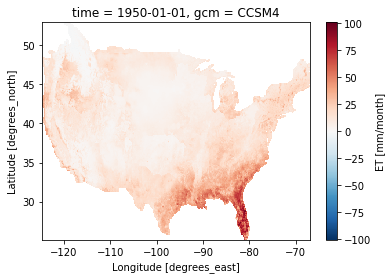

In [6]:
# load an xarray dataset
# airtemps = xr.tutorial.open_dataset('air_temperature').load()

# airtemps = xr.tutorial.load_dataset('air_temperature')
# display(airtemps)
# airtemps['air'].isel(time=0).plot()

hydro_vars = ['ET', 'total_runoff', 'SWE']
airtemps = hist_data['bcsd']['ET'].isel(time=0, gcm=1)
display(airtemps)
hist_data['bcsd']['ET'].isel(time=0, gcm=1).plot()

<xarray.Dataset>
Dimensions:       (lat: 222, lon: 462)
Coordinates:
  * lat           (lat) float32 25.1875 25.3125 25.4375 ... 52.6875 52.8125
    time          datetime64[ns] 1950-01-01
  * lon           (lon) float32 -124.6875 -124.5625 ... -67.1875 -67.0625
    gcm           <U14 'CCSM4'
Data variables:
    ET            (lat, lon) float32 dask.array<shape=(222, 462), chunksize=(222, 462)>
    total_runoff  (lat, lon) float32 dask.array<shape=(222, 462), chunksize=(222, 462)>
    SWE           (lat, lon) float32 dask.array<shape=(222, 462), chunksize=(222, 462)>
Attributes:
    Conventions:        GDT 1.2
    file_name:          conus_c5.access1-0_rcp85_r1i1p1.monthly.rhum.1956.nc
    History:            Archived Dec 2013
    authors:            Wood, A. and Mizukami, N., with codes from T. Pruitt,...
    description:        Monthly Average VIC Model Output for 1/8th Degree CON...
    creation_date:      2014
    institution:        NCAR, USACE, USBR
    SurfSgnConvention:  Tradit

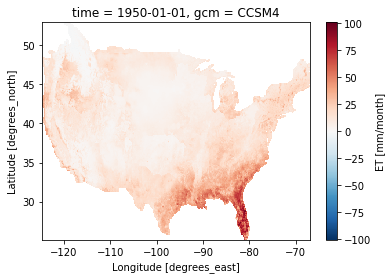

In [23]:
# airtemps = hist_data['bcsd'].isel(time=0, gcm=1)
# display(airtemps)
# hist_data['bcsd']['ET'].isel(time=0, gcm=1).plot()

<xarray.DataArray 'region' (lat: 222, lon: 462)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 25.1875 25.3125 25.4375 ... 52.5625 52.6875 52.8125
  * lon      (lon) float32 -124.6875 -124.5625 -124.4375 ... -67.1875 -67.0625

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.17:51991 remote=tcp://10.148.10.17:37648>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.10.17:52079 remote=tcp://10.148.10.17:37648>


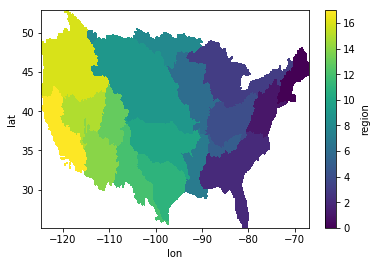

In [26]:
# Create a mask object
mask = huc_mask.mask(airtemps, wrap_lon=False)
display(mask)
mask.plot()

In [ ]:
# Group data by huck. 
data_by_huc = airtemps.groupby(mask).mean('stacked_lat_lon')
display(data_by_huc)

In [ ]:
# calculate the annual cycle and plot
data_by_huc.air.groupby('time.month').mean('time').plot()